In [4]:
# Set a small increment value for numerical differentiation
h = 0.0001

# Define three constants to be used in the evaluation formula
a = 2.0
b = -3.0 
c = 10.0

# Calculate the initial result of the formula a*b + c
d1 = a*b + c

# Increment c by h and recalculate the result to observe the change
c += h
d2 = a*b + c

# Print the results of the calculations
print(f"{d1=}")
print(f"{d2=}")
print(f"Slope = {(d2 - d1) / h}")

d1=4.0
d2=4.0001
Slope = 0.9999999999976694


In [7]:
import graphviz  
from IPython.display import display, SVG

def get_nodes_edges(root):
# build a set upt with all the nodes and edges
    nodes, edges = set(), set()

def get_nodes_edges(root):
    # build a set upt with all the nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
    ps = graphviz.Digraph(format = 'svg', graph_attr = {'rankdir' : 'LR'} )
    
    nodes, edges = get_nodes_edges(root)

    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangle with the data of the value
        ps.node(uid, label = "{%s | data %.3f | grad %.3f}" % (n.label, n.data, n.grad), shape = 'record') 
        
        if n._op:
            #if this value is a result of an operation, create a circle with the operation
            ps.node(name =uid + n._op, label = n._op)
            #create an edge between the value and the operation
            ps.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect the nodes
        ps.edge(str(id(n1)), str(id(n2)) + n2._op )

    svg_data = ps.pipe(format='svg')
    display(SVG(svg_data))

In [29]:
import math
class value():
    def __init__(self, data, _children = (), _op = None, label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label

    def __repr__(self):
        return  f" Value(data={self.data})"
    
    def __add__(self,other):
        if isinstance(other,value):
            out = value(self.data + other.data, (self,other), '+')
            self.grad = out.grad
            return out
    
    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1) / (math.exp(2*n) +1)
        out = value(tanh, (self, ) , 'tanh')
        return out

    def __mul__(self,other):
        if isinstance(other,value):
            return value(self.data * other.data, (self,other), '*')
        
a = value(3, label = 'a')
b = value(5, label = 'b')
c = a + b; c.label= 'c'
d = a * b + c; d.label = 'd'

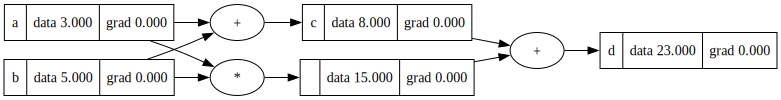

In [11]:
draw_graph(d)

In [54]:
#Inputs x1, x2
x1 = value(2.0, label = "x1")
x2 = value(0.0, label = "x2")
# weights w1, w2
w1 = value(-3.0, label = "w1")
w2 = value(1.0, label = "w2")
#bias of the neuron
b = value(6.7, label = 'b')
#x1*w1 + x2*b2 
x1w1 = x1*w1; x1w1.label = "x1w1"    
x2w2 = x2*w2; x2w2.label = "x2w2"
# add bias
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b;  n.label = "n"
o = n.tanh(); o.label = "o"

AttributeError: 'NoneType' object has no attribute 'label'

In [50]:
o.grad = 1
n.grad = 0.64
b.grad = 0.64
x1w1x2w2.grad = 0.64
x2w2.grad = 0.64
x1w1.grad = 0.64

w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

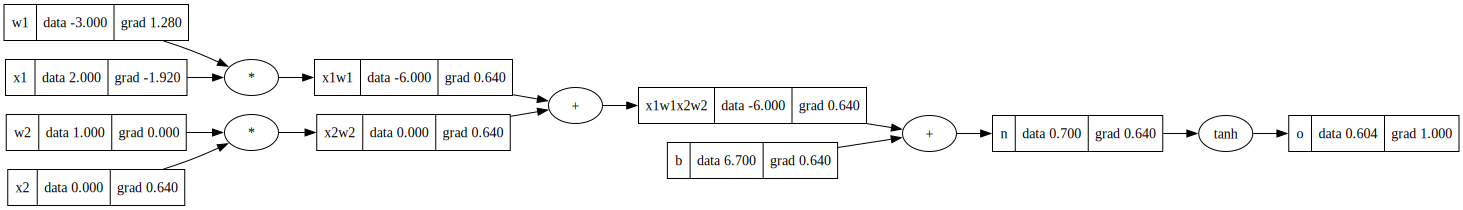

In [51]:
draw_graph(o)

In [81]:
import math
class value():
    def __init__(self, data, _children = (), _op = None, label = ''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return  f" Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,value) else value(other)  
        out = value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad +=  out.grad  # < -------
            other.grad += out.grad # < -------
        out._backward = _backward
        return out  
    
    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1) / (math.exp(2*n) +1)
        out = value(tanh, (self, ) , 'tanh')

        def _backward():
            self.grad += (1 - tanh**2) * out.grad
        out._backward = _backward
        return out


    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other) 
        out = value(self.data * other.data, (self,other), '*')
        def _backward():    
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        


In [84]:
#Inputs x1, x2
x1 = value(2.0, label = "x1")
x2 = value(0.0, label = "x2")
# weights w1, w2
w1 = value(-3.0, label = "w1")
w2 = value(1.0, label = "w2")
#bias of the neuron
b = value(6.7, label = 'b')
#x1*w1 + x2*b2 
x1w1 = x1*w1; x1w1.label = "x1w1"    
x2w2 = x2*w2; x2w2.label = "x2w2"
# add bias
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b;  n.label = "n"
o = n.tanh(); o.label = "o"

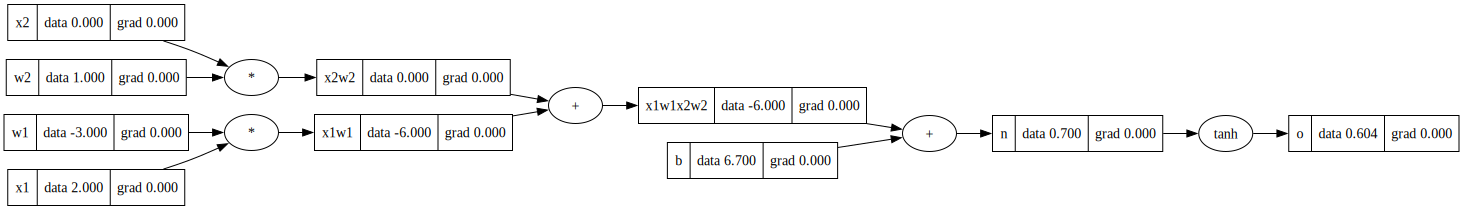

In [85]:
draw_graph(o)

0.6347395899824584


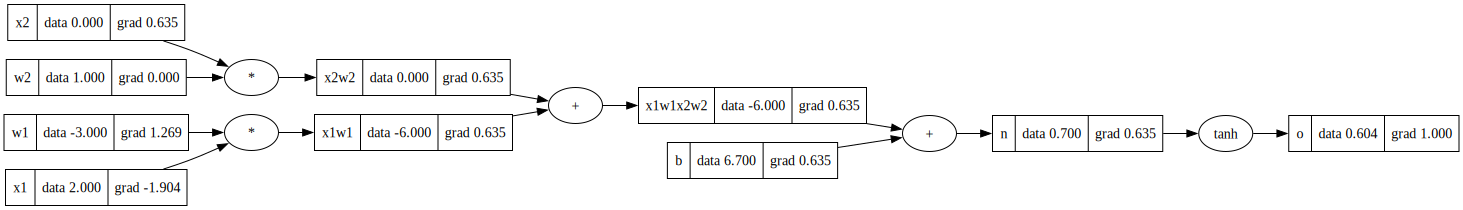

In [86]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x2w2._backward()
x1w1._backward()
x2._backward()
w2._backward()
w1._backward()
x1._backward()
draw_graph(o)

In [87]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

In [88]:
topo

[ Value(data=-3.0),
  Value(data=2.0),
  Value(data=-6.0),
  Value(data=1.0),
  Value(data=0.0),
  Value(data=0.0),
  Value(data=-6.0),
  Value(data=6.7),
  Value(data=0.7000000000000002),
  Value(data=0.6043677771171636)]

In [ ]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

In [132]:
import numpy as np
###########Part 1 ###########

class value():
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0
        
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __add__(self,other):
        other = other if isinstance(other,value) else value(other)  
        out = value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad +=  out.grad
            other.grad += out.grad
        out._backward = _backward
        return out  

    def exp(self):
        x = self.data
        t =  np.exp(x)
        out = value(t, (self,), 'exp')
        def _backward():
            self.grad += t * out.grad
        out._backward = _backward
        return out
    
    def div(self, other):
        other = other if isinstance(other,value) else value(other)  
        out = value(self.data / other.data, (self,other), '/')
        def _backward():
            self.grad += 1 / other.data * out.grad
            other.grad += -self.data / (other.data ** 2) * out.grad
        out._backward = _backward
        return out
    

    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other) 
        out = value(self.data * other.data, (self,other), '*')
        def _backward():    
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
        
    def __pow__(self,other):    
        assert isinstance(other, (int,float)), "Power must be a scalar"
        out = value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad  
        out._backward = _backward
        return out
    
    def relu(self):
        out = value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        #e = (2*n).exp()
        #tanh = (e-1)/(e+1)
        tanh = (math.exp(2*n) - 1) / (math.exp(2*n) +1)
        out = value(tanh, (self, ) , 'tanh')

        def _backward():
            self.grad += (1 - tanh**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    ############Part 2 ###########

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

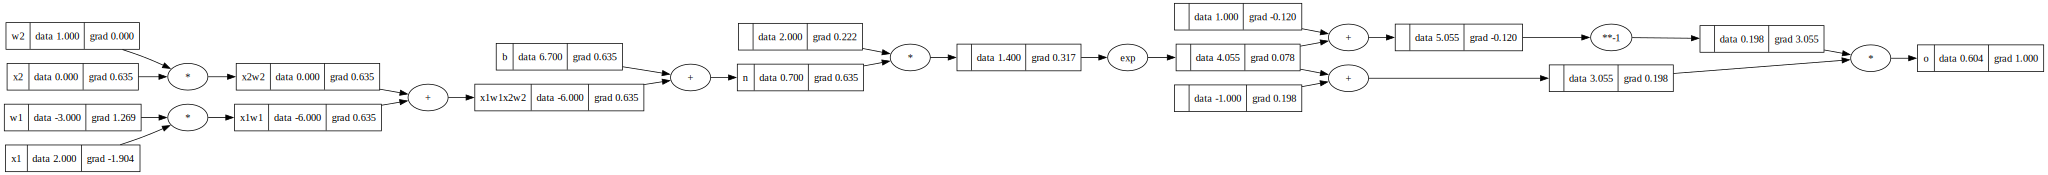

In [105]:
#Inputs x1, x2
x1 = value(2.0, label = "x1")
x2 = value(0.0, label = "x2")
# weights w1, w2
w1 = value(-3.0, label = "w1")
w2 = value(1.0, label = "w2")
#bias of the neuron
b = value(6.7, label = 'b')
#x1*w1 + x2*b2 
x1w1 = x1*w1; x1w1.label = "x1w1"    
x2w2 = x2*w2; x2w2.label = "x2w2"
# add bias
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b;  n.label = "n"
#----
e = (2*n).exp()
o = (e-1)/(e+1); o.label = "o"
#----
o.backward()
draw_graph(o)

In [173]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = random.uniform(-1,1)

    #Forward pass of this neuron
    def __call__(self, x):
        act = sum((wi * xi for wi , xi in list(zip(self.w, x))), self.b)
        out = act.tanh()
        return out
        #return w_x[0] if len(x_w) == 1

class Layer: 
    def __init__(self, nin, nout):
        """
        Layer initialization class
        
        This function will create a list of neurons based on the input arguments. These neurons will be used in the call function later.

        Args
        nin: Input dimensionallity, for example in this case it X is 3
        nout: Number of neurons that I want to create
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        """
        Function to call the neurons created in the initialization and apply forward pass

        Args
        x: Input values
        """
        out = [neuron(x) for neuron in self.neurons]
        return out
    
class MLP:
    def __init__(self, nin, nouts):
        """
        This function initiallize the numbers of layers required

        Args
        nin: Input dimensionallity, necessary to initiallize each neuron weights
        nouts: list of neurons per layer, it will define how many layers and neurons are needed
        """
        sz = [nin] + nouts  
        print(f"{sz=}")
        #layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        print(f"{len(nouts)=}")
        for i in range(len(nouts)):
            print(f"{i=}")
            print(f"{sz[i]=}")
            print(f"{sz[i+1]=}")

x = [1.3, 2.1, 1.7]
l = MLP(3, [5, 5, 1])


sz=[3, 5, 5, 1]
len(nouts)=3
i=0
sz[i]=3
sz[i+1]=5
i=1
sz[i]=5
sz[i+1]=5
i=2
sz[i]=5
sz[i+1]=1


In [174]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
    ]
ygt = [1.0, -1.0, -1.0, 1.0]

In [175]:
y_pred = [n(x) for x in xs]
loss = sum((ygt - yout)**2 for ygt, yout in list(zip(ygt, y_pred)))
loss

Value(data=0.532236287306165, grad=0)

In [176]:
y_pred

[Value(data=0.8064287379130923, grad=0),
 Value(data=-0.6474686238433255, grad=0),
 Value(data=-0.8794661119331961, grad=0),
 Value(data=0.4033764466157684, grad=0)]